In [1]:
import numpy as np
import pandas as pd
import os
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [3]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_16564\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [4]:
# Load your data
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])
raw_sales_df = raw_sales_df.sort_values('datesold')
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'])
ma_lga_df = ma_lga_df.sort_values('saledate')

# Merge moving average data with sales data based on date and property type
merged_df = pd.merge(raw_sales_df, ma_lga_df, left_on=['datesold', 'propertyType', 'bedrooms'], 
                     right_on=['saledate', 'type', 'bedrooms'], how='left')

# Feature selection: Use 'price' and 'MA' (moving average) as features
merged_df = merged_df[['datesold', 'price', 'MA']].dropna()

# Scale the features
scaler = StandardScaler()
features = scaler.fit_transform(merged_df[['price', 'MA']])

In [12]:
def find_optimal_states(features, max_states=10):
    """
    Find the optimal number of states for HMM based on AIC and BIC.
    
    Args:
    - features (numpy.ndarray): Scaled feature matrix.
    - max_states (int): Maximum number of hidden states to test.

    Returns:
    - optimal_states_aic (int): Optimal number of states based on AIC.
    - optimal_states_bic (int): Optimal number of states based on BIC.
    - aic_scores (list): List of AIC values for each number of states.
    - bic_scores (list): List of BIC values for each number of states.
    """
    aic_scores = []
    bic_scores = []
    models = []
    
    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states
        hmm = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42, n_iter=100)
        hmm.fit(features)
        models.append(hmm)
        
        # Calculate log likelihood
        log_likelihood = hmm.score(features)
        
        # Number of parameters
        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1
        
        # Calculate AIC and BIC
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(features)) * num_params - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    # Find optimal number of states
    optimal_states_aic = 2 + np.argmin(aic_scores)
    optimal_states_bic = 2 + np.argmin(bic_scores)
    
    return optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models

# Call the function and get AIC/BIC values
optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features, max_states=10)

print(f"Optimal number of states based on AIC: {optimal_states_aic}")
print(f"Optimal number of states based on BIC: {optimal_states_bic}")


Optimal number of states based on AIC: 7
Optimal number of states based on BIC: 3


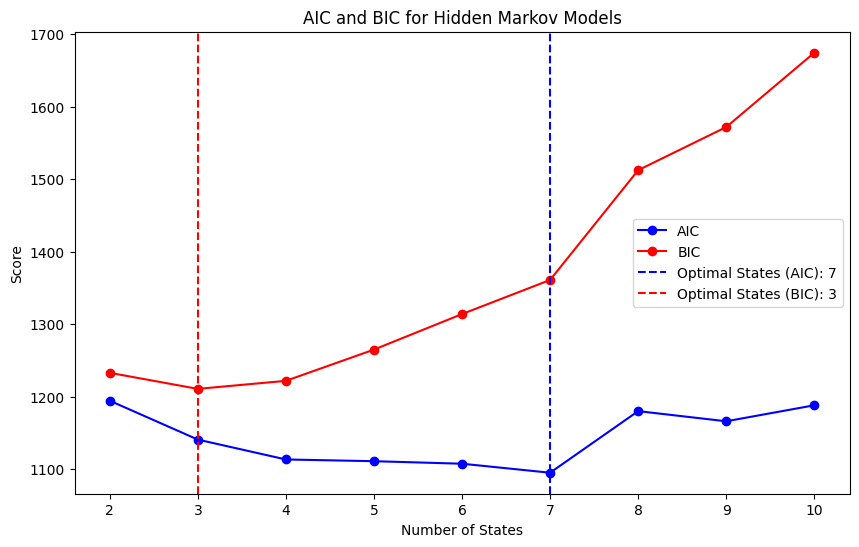

In [6]:
# Plot AIC and BIC
states_range = range(2, len(aic_scores) + 2)

plt.figure(figsize=(10, 6))
plt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')
plt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')
plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')
plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')
plt.xlabel('Number of States')
plt.ylabel('Score')
plt.title('AIC and BIC for Hidden Markov Models')
plt.legend()
plt.show()


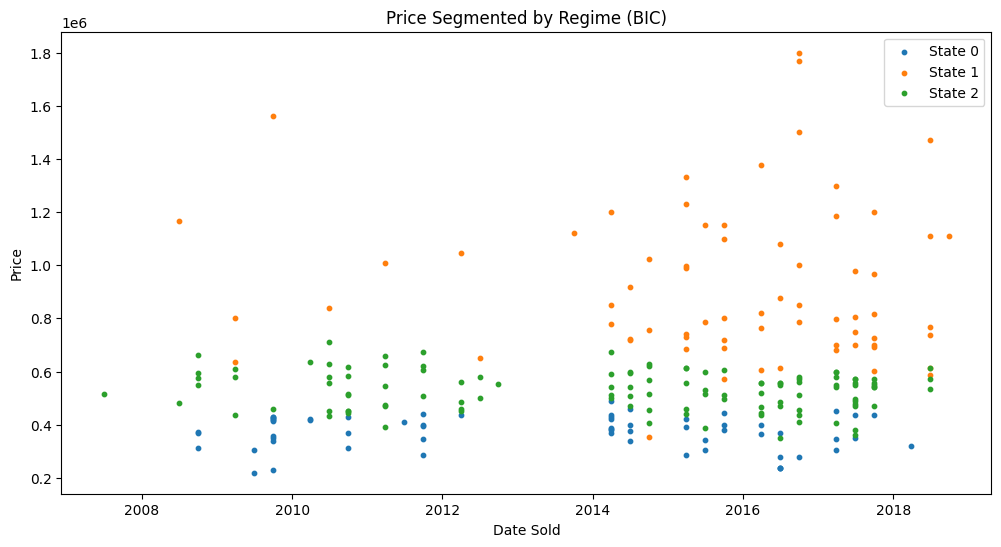

In [14]:
# Use the model with the optimal number of states based on BIC or AIC
best_model = models[optimal_states_bic - 2]  # Adjust for 0-indexing in the models list
hidden_states = best_model.predict(features)

# Add hidden states to the dataframe
merged_df['Regime'] = hidden_states

# Plot the regimes over time
plt.figure(figsize=(12, 6))
for state in range(best_model.n_components):
    state_data = merged_df[merged_df['Regime'] == state]
    plt.scatter(state_data['datesold'], state_data['price'], label=f'State {state}', s=10)

plt.legend()
plt.title('Price Segmented by Regime (BIC)')
plt.xlabel('Date Sold')
plt.ylabel('Price')
plt.show()
